## Inicialización
Primero sincronizamos con Drive e importamos las librerias

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import cv2
from collections import deque
import copy
import random
from random import sample
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
from math import pi

En la siguiente celda se definen las constantes del programa

In [4]:
COLOR_WATER = [255, 0, 0]
COLOR_GROUND = [37, 73, 141]
COLOR_TRAVEL = [0, 0, 255]
COLOR_BUOY = [0, 233, 255]
COLOR_PORT = [154, 152, 150]
COLOR_DESTINY_PORT = [0, 255, 0]
COLOR_STORM = [0, 0, 0]

ID_GROUND = 0
ID_WATER = 1
ID_PORT = 2
ID_DESTINY_PORT = 3
ID_BUOY = 4
ID_BOAT = 5
ID_STORM = 6
ID_TRAVEL = 7
ID_OLD_BUOY = 8
ID_STORM_TRAVEL = 9

BUOY_POSITION = [[20, 75], [35, 40], [50, 62], [80, 21], [68, 36], [92, 60], [23, 54], [65, 65], [80, 60], [60, 40], [54, 50], [43, 45], [44, 62], [77, 20], [49, 35], [78, 47], [35, 46], [18, 82], [10, 77], [32, 40], [52, 61], [99, 64], [30, 70], [54, 80], [40, 53], [64, 60]]
MAX_PORTS = 10
#PORT_POSITION = ["""[20,52],""" [41,40], [60, 22], [78,29], """[89, 32], [25, 82], [37, 72], """[49, 72], [62,72]""", [88,68]"""]
PORT_POSITION = [[41,40], [60, 22], [78,29], [49, 72], [62,72]]


STORM_POSITION  = [[[35,40], [55, 65]], [[55,75], [45, 50]], [[90,95], [50, 55]]]

FPS = 50
SIZE_RENDER = (355, 533)
SIZE_GAME = (100, 100)
X_MIN = 100
X_MAX = 300
Y_MIN = 50
Y_MAX = 200

#MOVES
UP = 0
DOWN = 1
LEFT = 2
RIGTH = 3

N_EPISODES = 150000
MAX_ITER = 400
#exploartion decreasing decay for exponential decreasing
EPSILON_DECREASING_DECAY = 0.99997
# minimum of exploration proba
MIN_EPSILON = 0.01
#discounted factor
DISCOUNT = 0.95
#learning rate
LEARNING_RATE = 0.1




DIRECTORI = '/content/drive/MyDrive/tfg/Proyecto/'

DIR_LIST = os.listdir(DIRECTORI)

Se crea el entorno de simulación como una clase

In [5]:
class Enviroment:
    def __init__(self):
        #Init variables and load the map
        self.list_frames = []
        self.state = []
        self.info = []
        self.done = False
        self.reward = 0
        self.old_buoy = False
        self.storm = False
        self.setPorts = False
        self.render_games = 1
        self.game = 0
        self.lim_render = True
        _, self.np_game = cv2.threshold(cv2.imread('/content/drive/MyDrive/tfg/Proyecto/Enviroment/img/mapa_mundi_binario.jpg',cv2.IMREAD_GRAYSCALE), 0, 1, cv2.THRESH_OTSU)
        self.__increment_duration(50)

        #Zoom the map
        self.__zoom()
        self.np_game = cv2.resize(self.np_game, SIZE_GAME, interpolation = cv2.INTER_AREA)
        self.__increment_duration(25)

        #Init static elements (storm, buoys and ports)
        for i in STORM_POSITION:
            for x in range(i[0][0], i[0][1]):
                for y in range(i[1][0], i[1][1]):
                    self.np_game[x, y] = ID_STORM
        for x, y in BUOY_POSITION:
            self.np_game[x, y] = ID_BUOY
        for x, y in PORT_POSITION:
            self.np_game[x, y] = ID_PORT

    #Function to add frames at video
    def __increment_duration(self, n_frames):
      if self.lim_render:
        if self.game == 0 or self.game == 4 or self.game % self.render_games == 0:
            for i in range(n_frames):
                self.list_frames.append(copy.copy(self.np_game))
  
    def set_lim_render(self, boolean):
      self.lim_render = boolean

    def set_render_games(self, x):
        self.render_games = x

    def set_ports(self, source, destiny):
      self.setPorts = True
      self.source = source
      self.destiny = destiny


    #Function to zoom the map
    def __zoom(self):
        step = 10
        x_min = 0
        x_max = self.np_game.shape[0]
        y_min = 0
        y_max = self.np_game.shape[1]
        static_frame = copy.copy(self.np_game)
        while x_min != X_MIN or x_max != X_MAX or y_min != Y_MIN or y_max != Y_MAX:
            x_min = min(X_MIN, x_min + step)
            x_max = max(X_MAX, x_max - step)
            y_min = min(Y_MIN, y_min + step)
            y_max = max(Y_MAX, y_max - step)
            self.np_game = static_frame[y_min:y_max, x_min:x_max]
            self.__increment_duration(10)

    #Function to create a video
    def render(self, name='output'):
        out = cv2.VideoWriter(DIRECTORI + name + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), FPS, SIZE_RENDER)
        for single_frame in self.list_frames:
            np_render = np.zeros((single_frame.shape[0], single_frame.shape[1], 3), dtype='uint8')

            np_render[single_frame==ID_WATER,:] = COLOR_WATER
            np_render[single_frame==ID_GROUND,:] = COLOR_GROUND
            np_render[single_frame==ID_STORM,:] = COLOR_STORM
            np_render[single_frame==ID_PORT,:] = COLOR_PORT
            np_render[single_frame==ID_BUOY,:] = COLOR_BUOY
            np_render[single_frame==ID_OLD_BUOY,:] = COLOR_BUOY
            np_render[single_frame==ID_DESTINY_PORT,:] = COLOR_DESTINY_PORT
            np_render[single_frame==ID_TRAVEL,:] = COLOR_TRAVEL
            np_render[single_frame==ID_STORM_TRAVEL,:] = COLOR_TRAVEL


            x, y = np.where(single_frame == ID_BOAT)
            if (x and y):
                x, y = x[0], y[0]
                np_render[x, y-3:y+3, :] = [65, 138, 222]
                np_render[x+1, y-2:y+2, :] = [65, 138, 222]
                np_render[x-4:x, y, :] = [0, 0, 0]
                np_render[x-4:x-1, y+1, :] = [255, 255, 255]
                np_render[x-3, y+2, :] = [255, 255, 255]


            data1 = cv2.resize(np_render, SIZE_RENDER, interpolation = cv2.INTER_AREA)
            out.write(data1)
        out.release()

    #Init variables of a game
    def reset(self):
        self.state.clear()
        self.info.clear()
        self.done = False
        self.game += 1

        self.np_game[((self.np_game==ID_BOAT) + (self.np_game==ID_TRAVEL))] = ID_WATER
        #Init static elements (storm, buoys and ports)
        for i in STORM_POSITION:
            for x in range(i[0][0], i[0][1]):
                for y in range(i[1][0], i[1][1]):
                    self.np_game[x, y] = ID_STORM
        for x, y in BUOY_POSITION:
            self.np_game[x, y] = ID_BUOY
        for x, y in PORT_POSITION:
            self.np_game[x, y] = ID_PORT

        if not self.setPorts:
          source, destiny = sample(range(0, MAX_PORTS-1), 2)
        else:
          source = self.source
          destiny = self.destiny

        self.np_game[PORT_POSITION[source][0], PORT_POSITION[source][1]] = ID_BOAT
        self.np_game[PORT_POSITION[destiny][0], PORT_POSITION[destiny][1]] = ID_DESTINY_PORT
        self.__increment_duration(25)
        x, y = np.where(self.np_game == ID_BOAT)
        self.state.append(x[0])
        self.state.append(y[0])
        x, y = np.where(self.np_game == ID_DESTINY_PORT)
        self.info.append(x[0])
        self.info.append(y[0])
        self.info.append(False)

        return self.state, self.info

    #Execute and action
    def step(self, action):
        self.info[2] = False

        if action == UP:
            self.info[2] = self.__move(self.state[0]-1, self.state[1])
        elif action == DOWN:
            self.info[2] = self.__move(self.state[0]+1, self.state[1])
        elif action == RIGTH:
            self.info[2] = self.__move(self.state[0], self.state[1]+1)
        elif action == LEFT:
            self.info[2] = self.__move(self.state[0], self.state[1]-1)
        else:
            print ("Uknow action")

        if self.info[2]:
            self.__increment_duration(10)

        

        return self.state, self.reward, self.done, self.info

    def __move(self, x, y):
        response = False
        self.reward = float('-inf')
        if x < SIZE_GAME[0] and x >= 0 and y < SIZE_GAME[1] and x >= 0: #Out of map don't move
            if not (self.np_game[x, y] == ID_GROUND or self.np_game[x, y] == ID_PORT): #Port or Ground don't move
                if self.old_buoy: #Reset place of buoy
                    self.np_game[self.state[0], self.state[1]] = ID_OLD_BUOY
                    self.old_buoy = False
                elif self.storm: #Reset place of storm
                    self.np_game[self.state[0], self.state[1]] = ID_STORM_TRAVEL
                    self.storm = False
                else:
                    self.np_game[self.state[0], self.state[1]] = ID_TRAVEL

                if self.np_game[x, y] == ID_WATER: #Wate
                    self.reward = -1
                elif self.np_game[x, y] == ID_TRAVEL: #Travel
                    self.reward = -1.5
                elif self.np_game[x, y] == ID_STORM or self.np_game[x, y] == ID_STORM_TRAVEL: #Storm or Storm travel
                    self.reward = -2
                    self.storm = True
                elif self.np_game[x, y] == ID_BUOY: #Bouy
                    self.reward = 20
                    self.old_buoy = True
                elif self.np_game[x, y] == ID_DESTINY_PORT: #Destiny port
                    self.reward = 200
                    self.done = True
                elif self.np_game[x,y] == ID_OLD_BUOY: #Old buoy
                    self.reward = -1.5
                    self.old_buoy = True
                else:
                    print('Uknow position: ', self.np_game[x,y])

                self.np_game[x,y] = ID_BOAT
                self.state[0] = x
                self.state[1] = y
            response = True
        return response



Función para decidir que acción tomar en función de la aleatoriedad y los valores de la matriz Q

In [6]:
def take_action(dict_q_tables, state, info, dict_name, epsilon):
    if dict_name not in dict_q_tables:
        dict_q_tables[dict_name] = np.full((SIZE_GAME[0],SIZE_GAME[1],4), float ('-inf'))
        return random.sample(range(4), 1)[0]
    else:
        if np.random.uniform(0,1) < epsilon:
          return random.sample(range(4), 1)[0]
        else:
          return np.argmax(dict_q_tables[dict_name][state[0], state[1]])

Función de actualización de la matriz Q en función de la versión que se este ejecutando

In [7]:
def update_q(dict_q_tables, dict_name, state, next_state, action, reward, version, info):
    if version in [1,2]:
        vector = [info[1]-state[1], (SIZE_GAME[0]-info[0])-(SIZE_GAME[0]-state[0])]
        angle = math.atan2(vector[1], vector[0]) * (180/math.pi)
        if version == 1:
            if action == UP and angle < 0:
              reward = reward*2 if reward<0 else reward
            elif action == DOWN and angle > 0:
              reward = reward*2 if reward<0 else reward
            elif action == LEFT and abs(angle) < 90:
              reward = reward*2 if reward<0 else reward
            elif action == RIGTH and abs(angle) > 90:
              reward = reward*2 if reward<0 else reward
        elif version == 2:
            if action == UP:
              if angle < -90:
                  new_angle = abs(270 + angle)
              else:
                  new_angle = abs(angle-90)
              reward = (reward*(1+new_angle/180)) if reward<0 else reward
            elif action == DOWN:
              if angle > 90:
                  new_angle = abs(270 - angle)
              else:
                  new_angle = abs(angle+90)
              reward = (reward*(1+new_angle/180)) if reward<0 else reward
            elif action == LEFT:
              new_angle = 180 - abs(angle)
              reward = (reward*(1+new_angle/180)) if reward<0 else reward
            elif action == RIGTH:
              reward = (reward*(1+(abs(angle))/180)) if reward<0 else reward
    
    value = dict_q_tables[dict_name][state[0], state[1], action]
    if value == float('-inf'):
      dict_q_tables[dict_name][state[0], state[1], action] = 0
    else:
      dict_q_tables[dict_name][state[0], state[1], action] = (1- LEARNING_RATE)*value

    next_value = np.max(dict_q_tables[dict_name][next_state[0], next_state[1]])
    if next_value == float('-inf'):
      dict_q_tables[dict_name][state[0], state[1], action] += LEARNING_RATE * reward
    else:
      dict_q_tables[dict_name][state[0], state[1], action] += LEARNING_RATE * (reward + DISCOUNT * next_value)

    return dict_q_tables[dict_name]

## Ejecución
Primero inicializamos los objetos y establecemos los parametros de configuración

In [8]:
env_final = Enviroment()
env_final.set_render_games(100000000)
dict_q_tables_final = {}

Se ejecuta la versión del código que no contiene ninguna heurística


In [9]:
version = 0
dict_q_tables_final[version] = {}

if False:
  for i in range(5):
    total_reward = 0
    prev_reward = 0
    #initialize the exploration probability to 1
    epsilon = 1
    list_sources = [x for x in range(5) if x != i]
    for episode in range (N_EPISODES+1):
        env_final.set_ports(list_sources[episode%len(list_sources)], i)
        state, info = env_final.reset()
        done = False
        iteration = 0
        episode_reward = 0
        dict_name = str(info[0])+str(info[1])
        while not done and iteration < MAX_ITER:
            #Take an action
            action = take_action(dict_q_tables_final[version], state, info, dict_name, epsilon)
            next_state, reward, done, info = env_final.step(action)
            #Update matrix Q
            if info[2]:
              ground = (reward == float('-inf'))
              if not ground:
                #Update reward
                episode_reward += reward
                dict_q_tables_final[version][dict_name] = update_q(dict_q_tables_final[version], dict_name, state, next_state, action, reward, version, info)
            #Update state
            state = copy.copy(next_state)
            iteration += 1
        
        #Actualizar epsilon
        if episode > N_EPISODES*0.015 and episode_reward > prev_reward:
            epsilon = max(MIN_EPSILON, math.pow(EPSILON_DECREASING_DECAY, episode - N_EPISODES*0.015))

        total_reward += episode_reward
        prev_reward = episode_reward
        
        if episode % 100 == 0 and episode > 0:
            print("Reward medio entre la iteración ", episode - 100, " y la iteración ", episode, " es de ", total_reward/100)
            print("Epsilon: ", epsilon)
            total_reward = 0

  #Guardar Q en archivo
  for dest, q in dict_q_tables_final[version].items():
    with open(DIRECTORI + 'final-' + str(version) + dest + '-q_table.npy', 'wb') as f:
      np.save(f, q)
else:
  for i in list(filter(lambda x: x.startswith('final-' + str(version)), DIR_LIST)):
    with open(DIRECTORI + i, 'rb') as f:
      dict_q_tables_final[version][i[7:11]] = np.load(f)

Se ejecuta la versión del código que contiene la heurística de no retroceso

In [10]:
version = 1
dict_q_tables_final[version] = {}

if False:
  for i in range(5):
    total_reward = 0
    prev_reward = 0
    #initialize the exploration probability to 1
    epsilon = 1
    list_sources = [x for x in range(5) if x != i]
    for episode in range (N_EPISODES+1):
        env_final.set_ports(list_sources[episode%len(list_sources)], i)
        state, info = env_final.reset()
        done = False
        iteration = 0
        episode_reward = 0
        dict_name = str(info[0])+str(info[1])
        while not done and iteration < MAX_ITER:
            #Take an action
            action = take_action(dict_q_tables_final[version], state, info, dict_name, epsilon)
            next_state, reward, done, info = env_final.step(action)
            #Update matrix Q
            if info[2]:
              ground = (reward == float('-inf'))
              if not ground:
                #Update reward
                episode_reward += reward
                dict_q_tables_final[version][dict_name] = update_q(dict_q_tables_final[version], dict_name, state, next_state, action, reward, version, info)
            #Update state
            state = copy.copy(next_state)
            iteration += 1
        
        #Actualizar epsilon
        if episode > N_EPISODES*0.015 and episode_reward > prev_reward:
            epsilon = max(MIN_EPSILON, math.pow(EPSILON_DECREASING_DECAY, episode - N_EPISODES*0.015))

        total_reward += episode_reward
        prev_reward = episode_reward
        
        if episode % 100 == 0 and episode > 0:
            print("Reward medio entre la iteración ", episode - 100, " y la iteración ", episode, " es de ", total_reward/100)
            print("Epsilon: ", epsilon)
            total_reward = 0

  #Guardar Q en archivo
  for dest, q in dict_q_tables_final[version].items():
    with open(DIRECTORI + 'final-' + str(version) + dest + '-q_table.npy', 'wb') as f:
      np.save(f, q)
else:
  for i in list(filter(lambda x: x.startswith('final-' + str(version)), DIR_LIST)):
    with open(DIRECTORI + i, 'rb') as f:
      dict_q_tables_final[version][i[7:11]] = np.load(f)

Se ejecuta la versión del código que contiene la heurística de dirección de destino

In [11]:
version = 2
dict_q_tables_final[version] = {}

if False:
  for i in range(5):
    total_reward = 0
    prev_reward = 0
    #initialize the exploration probability to 1
    epsilon = 1
    list_sources = [x for x in range(5) if x != i]
    for episode in range (N_EPISODES+1):
        env_final.set_ports(list_sources[episode%len(list_sources)], i)
        state, info = env_final.reset()
        done = False
        iteration = 0
        episode_reward = 0
        dict_name = str(info[0])+str(info[1])
        while not done and iteration < MAX_ITER:
            #Take an action
            action = take_action(dict_q_tables_final[version], state, info, dict_name, epsilon)
            next_state, reward, done, info = env_final.step(action)
            #Update matrix Q
            if info[2]:
              ground = (reward == float('-inf'))
              if not ground:
                #Update reward
                episode_reward += reward
                dict_q_tables_final[version][dict_name] = update_q(dict_q_tables_final[version], dict_name, state, next_state, action, reward, version, info)
            #Update state
            state = copy.copy(next_state)
            iteration += 1
        
        #Actualizar epsilon
        if episode > N_EPISODES*0.015 and episode_reward > prev_reward:
            epsilon = max(MIN_EPSILON, math.pow(EPSILON_DECREASING_DECAY, episode - N_EPISODES*0.015))

        total_reward += episode_reward
        prev_reward = episode_reward
        
        if episode % 100 == 0 and episode > 0:
            print("Reward medio entre la iteración ", episode - 100, " y la iteración ", episode, " es de ", total_reward/100)
            print("Epsilon: ", epsilon)
            total_reward = 0

  #Guardar Q en archivo
  for dest, q in dict_q_tables_final[version].items():
    with open(DIRECTORI + 'final-' + str(version) + dest + '-q_table.npy', 'wb') as f:
      np.save(f, q)
else:
  for i in list(filter(lambda x: x.startswith('final-' + str(version)), DIR_LIST)):
    with open(DIRECTORI + i, 'rb') as f:
      dict_q_tables_final[version][i[7:11]] = np.load(f)

## Evaluación
Se ejecutan todos los posibles caminos para todas la versiones y se obtienen las estadísticas

In [12]:
df_final = pd.DataFrame(columns=['Version', 'Destiny', 'Travel', 'Success', 'Reward', 'Steps', 'Buoys'], dtype='int')
env2 = Enviroment()
for version in range(3):
  for destiny in range(5):
    list_sources = [x for x in range(5) if x != destiny]
    for travel in list_sources:
      pd_done = 0
      pd_reward = 0
      pd_iteration = 0
      pd_buoys = 0
      for episode in range(1):
        env2.set_ports(travel, destiny)
        state, info = env2.reset()
        done = False
        iteration = 0
        dict_name = str(info[0])+str(info[1])
        while not done and iteration < 100:
          action = np.argmax(dict_q_tables_final[version][dict_name][state[0], state[1]])
          state, reward, done, info = env2.step(action)
          iteration += 1
          pd_reward += reward
          pd_buoys += (reward == 20)
        pd_done += done
        pd_iteration += iteration
      record = [version, destiny, travel, pd_done, pd_reward, pd_iteration, pd_buoys]
      df_final.loc[len(df_final.index)] = record
df_final.round(0).head()

,Version,Destiny,Travel,Success,Reward,Steps,Buoys
0,0.0,0.0,1.0,1.0,183.0,39.0,1.0
1,0.0,0.0,2.0,1.0,193.0,50.0,2.0
2,0.0,0.0,3.0,1.0,203.0,40.0,2.0
3,0.0,0.0,4.0,1.0,211.0,53.0,3.0
4,0.0,1.0,0.0,1.0,183.0,39.0,1.0


In [13]:
df_final.loc[(df_final['Success'] == 0.0)]

,Version,Destiny,Travel,Success,Reward,Steps,Buoys
14,0.0,3.0,2.0,0.0,-119.0,100.0,1.0
41,2.0,0.0,2.0,0.0,-120.5,100.0,1.0
47,2.0,1.0,4.0,0.0,-124.0,100.0,1.0


In [14]:
df_final.groupby('Version').sum()

,Destiny,Travel,Success,Reward,Steps,Buoys
Version,,,,,,
0.0,40.0,40.0,19.0,3636.0,982.0,41.0
1.0,40.0,40.0,20.0,4017.0,954.0,46.0
2.0,40.0,40.0,18.0,3342.5,1040.0,41.0


Se añade información sobre la distancia que existe entre los puertos implicados

In [15]:
manhatan_distance = []
for destiny in range(5):
  list_sources = [x for x in range(5) if x != destiny]
  for source in list_sources:
    manhatan_distance.append(sum(abs(val1-val2) for val1, val2 in zip(PORT_POSITION[source],PORT_POSITION[destiny])))
df_final['Distance'] = np.tile(manhatan_distance,3)

df_final.head()

,Version,Destiny,Travel,Success,Reward,Steps,Buoys,Distance
0,0.0,0.0,1.0,1.0,183.0,39.0,1.0,37
1,0.0,0.0,2.0,1.0,193.0,50.0,2.0,48
2,0.0,0.0,3.0,1.0,203.0,40.0,2.0,40
3,0.0,0.0,4.0,1.0,211.0,53.0,3.0,53
4,0.0,1.0,0.0,1.0,183.0,39.0,1.0,37


Se extrae un dataset exluyendo los caminos que no hayan sido completados con éxito por una versión o más

In [16]:
mylist  = ((df_final.Destiny == 3) & (df_final.Travel == 2)) | ((df_final.Destiny == 0) & (df_final.Travel == 2)) | ((df_final.Destiny == 1) & (df_final.Travel == 4))
mylist = [not elem for elem in mylist]
df_aux = df_final[mylist].groupby(['Destiny', 'Travel', 'Reward']).sum()
index = df_aux.loc[df_aux['Success'] < 3].index
list_dest_sour = np.full((60,), False)
for dest, sour, rew in index:
  list_dest_sour |= ((df_final.Destiny == dest) & (df_final.Travel == sour))#(dest, sour, rew)
df_aux2 = df_final[list_dest_sour].groupby('Version').sum()
df_aux2

,Destiny,Travel,Success,Reward,Steps,Buoys,Distance
Version,,,,,,,
0.0,16.0,18.0,7.0,1442.0,431.0,23.0,417
1.0,16.0,18.0,7.0,1470.0,431.0,24.0,417
2.0,16.0,18.0,7.0,1434.0,425.0,22.0,417


Estadísticas del reward de cada versión

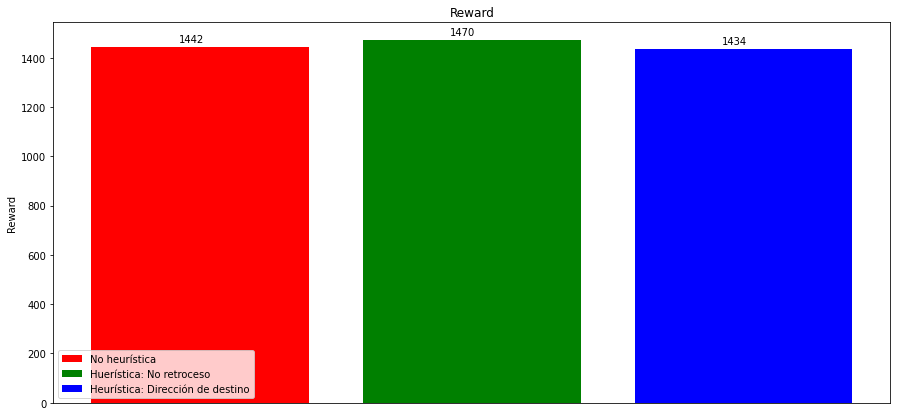

In [17]:
s = np.zeros([3,3])
s[0,:] = df_aux2.iloc[[0]][['Reward', 'Steps', 'Buoys']].values.flatten().tolist()
s[1,:] = df_aux2.iloc[[1]][['Reward', 'Steps', 'Buoys']].values.flatten().tolist()
s[2,:] = df_aux2.iloc[[2]][['Reward', 'Steps', 'Buoys']].values.flatten().tolist()

fig, ax = plt.subplots(figsize=(15,7))
plt.bar(0.25, s[0, 0], width=0.2, color='r')
plt.bar(0.5, s[1, 0], width=0.2, color='g')
plt.bar(0.75, s[2, 0], width=0.2, color='b')

ax.text(0.23, s[0][0] + 20, str(int(s[0][0])))
ax.text(0.48, s[1][0] + 20, str(int(s[1][0])))
ax.text(0.73, s[2][0] + 20, str(int(s[2][0])))

plt.xticks([])
plt.ylabel("Reward")
plt.title('Reward')
plt.legend(['No heurística', 'Huerística: No retroceso', 'Heurística: Dirección de destino'], loc="lower left")

plt.show()

Estadísticas de los pasos de cada versión

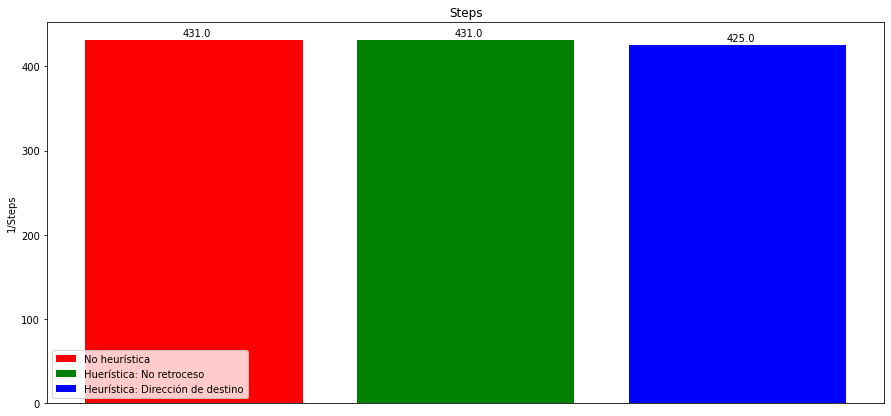

In [18]:
fig, ax = plt.subplots(figsize=(15,7))
plt.bar(0.3, s[0, 1], width=0.2, color='r')
plt.bar(0.55, s[1, 1], width=0.2, color='g')
plt.bar(0.8, s[2, 1], width=0.2, color='b')

ax.text(0.29, s[0][1] + 5, str((s[0][1])))
ax.text(0.54, s[1][1] + 5, str((s[1][1])))
ax.text(0.79, s[2][1] + 5, str((s[2][1])))

plt.xticks([])
plt.ylabel("1/Steps")
plt.title('Steps')
plt.legend(['No heurística', 'Huerística: No retroceso', 'Heurística: Dirección de destino'], loc="lower left")

plt.show()

Estadísticas de las boyas cruzadas de cada versión

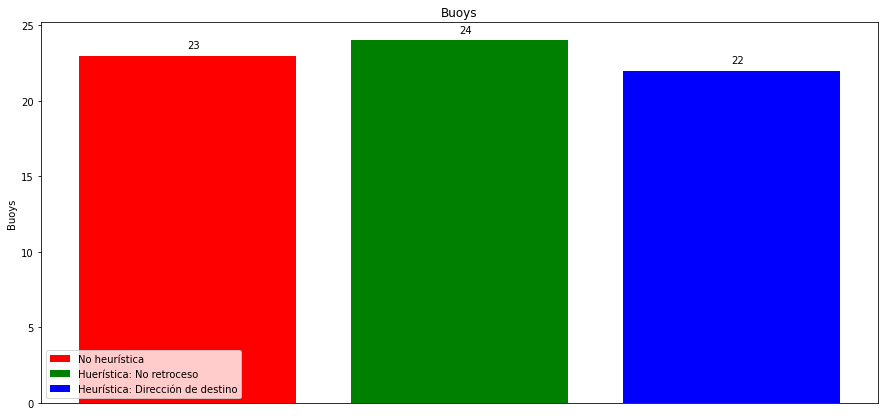

In [19]:
fig, ax = plt.subplots(figsize=(15,7))
plt.bar(0.25, s[0, 2], width=0.2, color='r')
plt.bar(0.5, s[1, 2], width=0.2, color='g')
plt.bar(0.75, s[2, 2], width=0.2, color='b')

ax.text(0.25, s[0][2] + 0.5, str(int(s[0][2])))
ax.text(0.50, s[1][2] + 0.5, str(int(s[1][2])))
ax.text(0.75, s[2][2] + 0.5, str(int(s[2][2])))

plt.xticks([])
plt.ylabel("Buoys")
plt.title('Buoys')
plt.legend(['No heurística', 'Huerística: No retroceso', 'Heurística: Dirección de destino'], loc="lower left")

plt.show()

Mapa de calor para entender el aprendizaje realizado por cada versión en un caso donde la versión dirección de destino no ha conseguido completar el camino con éxito

Area sin heurística:  16856
Area sin heurística:  3939
Area heurística de no retroceso:  14731
Area heurística de no retroceso:  4852
Area heurística de dirección de destino:  15107
Area heurística de dirección de destino:  4458


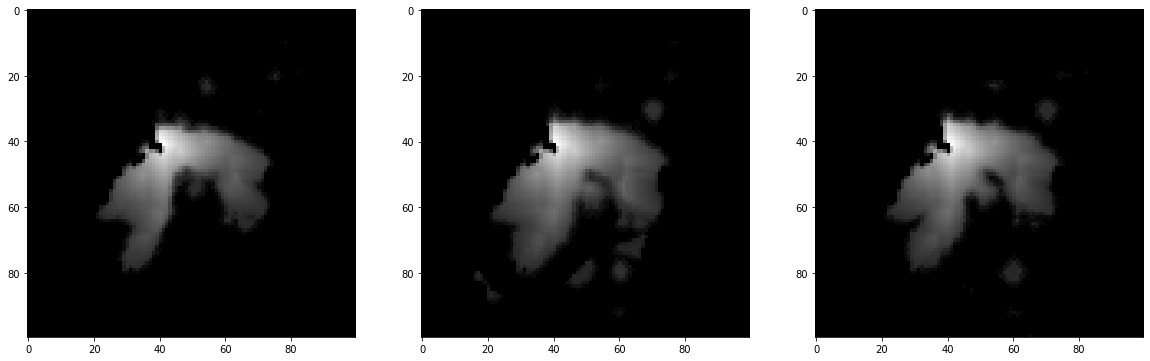

In [20]:
fig = plt.figure(figsize=(20, 7))
explorer0 = np.sum(np.where(dict_q_tables_final[0]['4140'] < 0, -30, dict_q_tables_final[0]['4140']), axis=2)
explorer1 = np.sum(np.where(dict_q_tables_final[1]['4140'] < 0, -30, dict_q_tables_final[1]['4140']), axis=2)
explorer2 = np.sum(np.where(dict_q_tables_final[2]['4140'] < 0, -30, dict_q_tables_final[2]['4140']), axis=2)

fig.add_subplot(1, 3, 1)
plt.imshow(explorer0, vmin=np.min(explorer0), vmax=np.max(explorer0), cmap='gray')
fig.add_subplot(1, 3, 2)
plt.imshow(explorer1, vmin=np.min(explorer1), vmax=np.max(explorer1), cmap='gray')
fig.add_subplot(1, 3, 3)
plt.imshow(explorer2, vmin=np.min(explorer2), vmax=np.max(explorer2), cmap='gray')
print('Area sin heurística: ', np.sum(dict_q_tables_final[0]['4140'] != float('-inf')))
print('Area sin heurística: ', np.sum(dict_q_tables_final[0]['4140'] > 10))
print('Area heurística de no retroceso: ', np.sum(dict_q_tables_final[1]['4140'] != float('-inf')))
print('Area heurística de no retroceso: ', np.sum(dict_q_tables_final[1]['4140'] >10))
print('Area heurística de dirección de destino: ', np.sum(dict_q_tables_final[2]['4140'] != float('-inf')))
print('Area heurística de dirección de destino: ', np.sum(dict_q_tables_final[2]['4140'] >10))

Mapa de calor para entender el aprendizaje realizado por cada versión en un caso donde la versión sin heurísticas no ha conseguido completar el camino con éxito

Area sin heurística:  16856
Area sin heurística:  4044
Area heurística de no retroceso:  15362
Area heurística de no retroceso:  4280
Area heurística de dirección de destino:  16248
Area heurística de dirección de destino:  4016


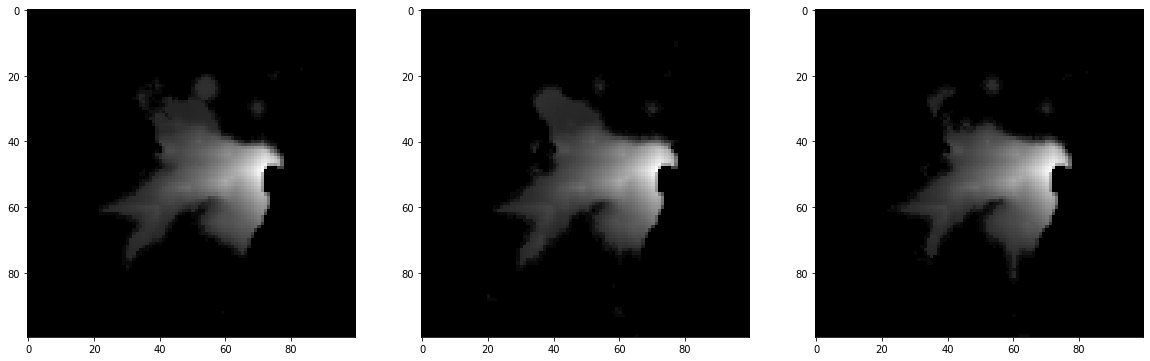

In [21]:
fig = plt.figure(figsize=(20, 7))
explorer0 = np.sum(np.where(dict_q_tables_final[0]['4972'] < 0, -30, dict_q_tables_final[0]['4972']), axis=2)
explorer1 = np.sum(np.where(dict_q_tables_final[1]['4972'] < 0, -30, dict_q_tables_final[1]['4972']), axis=2)
explorer2 = np.sum(np.where(dict_q_tables_final[2]['4972'] < 0, -30, dict_q_tables_final[2]['4972']), axis=2)

fig.add_subplot(1, 3, 1)
plt.imshow(explorer0, vmin=np.min(explorer0), vmax=np.max(explorer0), cmap='gray')
fig.add_subplot(1, 3, 2)
plt.imshow(explorer1, vmin=np.min(explorer1), vmax=np.max(explorer1), cmap='gray')
fig.add_subplot(1, 3, 3)
plt.imshow(explorer2, vmin=np.min(explorer2), vmax=np.max(explorer2), cmap='gray')
print('Area sin heurística: ', np.sum(dict_q_tables_final[0]['4972'] != float('-inf')))
print('Area sin heurística: ', np.sum(dict_q_tables_final[0]['4972'] > 10))
print('Area heurística de no retroceso: ', np.sum(dict_q_tables_final[1]['4972'] != float('-inf')))
print('Area heurística de no retroceso: ', np.sum(dict_q_tables_final[1]['4972'] >10))
print('Area heurística de dirección de destino: ', np.sum(dict_q_tables_final[2]['4972'] != float('-inf')))
print('Area heurística de dirección de destino: ', np.sum(dict_q_tables_final[2]['4972'] >10))

Generación de un video de todas las versiones para un único camino

In [22]:
env2 = Enviroment()
for version in range(3):
  for destiny in range(1): # Cambiar el 1 por un 5 para obtener todos los posibles caminos
    list_sources = [x for x in range(5) if x != destiny]
    for travel in list_sources:
      pd_done = 0
      pd_reward = 0
      pd_iteration = 0
      pd_buoys = 0
      for episode in range(1):
        env2.set_ports(travel, destiny)
        state, info = env2.reset()
        done = False
        iteration = 0
        dict_name = str(info[0])+str(info[1])
        while not done and iteration < 100:
          action = np.argmax(dict_q_tables_final[version][dict_name][state[0], state[1]])
          state, reward, done, info = env2.step(action)
          iteration += 1
          pd_reward += reward
          pd_buoys += (reward == 20)
        pd_done += done
        pd_iteration += iteration
env2.render()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
